# Molecular lipophilicity prediction

## Introduction

In this notebook I will use for the first time RDKit library. RDKit is a powerful Python library widely employed in data science projects, particularly in the fields of cheminformatics and molecular modeling. It serves as an essential toolkit for working with chemical data, providing tools for molecular structure representation, substructure searching, molecular fingerprinting, and more. RDKit's versatility supports tasks ranging from compound screening and virtual compound generation to drug discovery and predictive modeling. With its comprehensive functionality and active community, RDKit empowers data scientists to analyze, visualize, and manipulate molecular data effectively, making it a cornerstone in the toolkit for chemistry-focused data science endeavors.

## logP prediction
**LogP**, or the **logarithm of the partition coefficient**, is a crucial molecular property in chemistry and drug discovery. It quantifies a molecule's **hydrophobicity**, indicating how likely a compound is to dissolve in **lipophilic** (hydrophobic) solvents compared to **hydrophilic** (water-based) solvents. LogP plays a significant role in predicting a molecule's behavior within biological systems, including its **absorption**, **distribution**, and **metabolism**.

Predicting LogP from a molecular structure is highly valuable because it offers insights into a compound's **bioavailability**, potential **toxicity**, and its ability to permeate **cell membranes**. Computational methods, such as **quantitative structure-property relationship (QSPR) models**, leverage features extracted from molecular structures to estimate LogP values. Accurate LogP prediction aids in rational **drug design** and optimization, guiding the selection and modification of molecules for **therapeutic** and **industrial applications**.

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit.Chem import Descriptors
from rdkit import Chem 
from rdkit.Chem import Draw
import warnings
#warnings.filterwarnings("ignore")

# EDA

In [97]:
# importing the dataset
df = pd.read_csv('logP_dataset.csv', names=['smiles', 'logP'])
df.head()

,smiles,logP
0,C[C@H]([C@@H](C)Cl)Cl,2.3
1,C(C=CBr)N,0.3
2,CCC(CO)Br,1.3
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0
4,CCCOCCP,0.6


We have 2 columns:
- SMILES representation of the molecules
- logP is our **target** feature

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14610 entries, 0 to 14609
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   smiles  14610 non-null  object 
 1   logP    14610 non-null  float64
dtypes: float64(1), object(1)
memory usage: 228.4+ KB


There are not null values.

Let's try to transform SMILES object into MOL represenation with RDkit.

In [99]:
#Method transforms smiles strings to mol rdkit object
df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x)) 

#Now let's see what we've got
print(type(df['mol'][0]))

<class 'rdkit.Chem.rdchem.Mol'>


We can easily visualize the molecular structure:

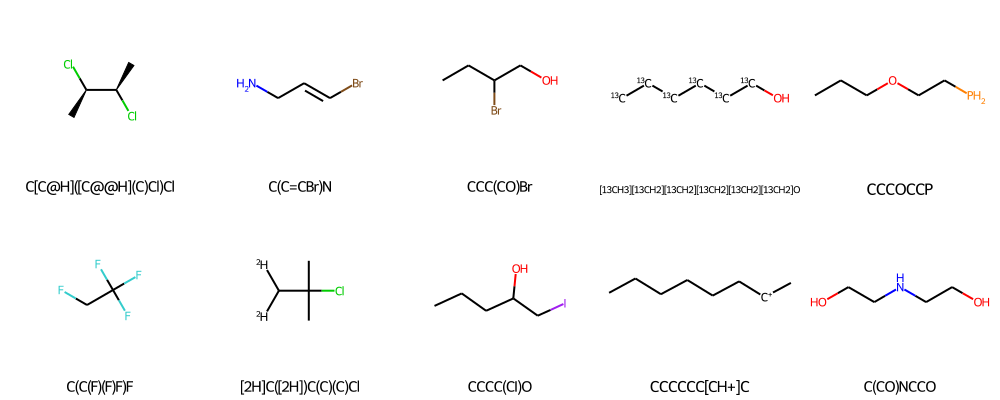

In [100]:
mols = df['mol'][:10]

#MolsToGridImage allows to paint a number of molecules at a time
Draw.MolsToGridImage(mols, molsPerRow=5, useSVG=True, legends=list(df['smiles'][:10].values))

Let's add Hs, because they are usually ignored. Then I count the total number for each atom in the dataset.

In [101]:
df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x)) # Add the hydrogens to the molecules

In [102]:
# Let's build a list of the MOL objects
mol_list = df['mol']

atom_counts = {}

# Counting the atoms
for mol in mol_list:
    # Conta il tipo di atomi
    for atom in mol.GetAtoms():
        atom_symbol = atom.GetSymbol()
        if atom_symbol in atom_counts:
            atom_counts[atom_symbol] += 1
        else:
            atom_counts[atom_symbol] = 1

sorted_atom_counts = dict(sorted(atom_counts.items(), key=lambda item: item[1], reverse=True))
print("sorted_atom_counts:", sorted_atom_counts)

sorted_atom_counts: {'H': 124321, 'C': 51970, 'O': 9386, 'N': 7609, 'S': 5221, 'Cl': 2930, 'P': 2893, 'F': 2157, 'I': 2085, 'Br': 1996}


As one would expect, H and C have the highest values, followed by the other heteroatoms. Let's add the number of atom of each molecule to the df:

In [105]:
def number_of_atoms(atom_list, df):
    for i in atom_list:
        df['num_of_{}_atoms'.format(i)] = df['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

number_of_atoms(['C', 'O', 'N', 'S', 'Cl', 'P', 'F', 'I', 'Br'], df)

df.head()

,smiles,logP,mol,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_S_atoms,num_of_Cl_atoms,num_of_P_atoms,num_of_F_atoms,num_of_I_atoms,num_of_Br_atoms
0,C[C@H]([C@@H](C)Cl)Cl,2.3,<rdkit.Chem.rdchem.Mol object at 0x1409af880>,4,0,0,0,2,0,0,0,0
1,C(C=CBr)N,0.3,<rdkit.Chem.rdchem.Mol object at 0x1409ae920>,3,0,1,0,0,0,0,0,1
2,CCC(CO)Br,1.3,<rdkit.Chem.rdchem.Mol object at 0x1409aea40>,4,1,0,0,0,0,0,0,1
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0,<rdkit.Chem.rdchem.Mol object at 0x1409aeaa0>,6,1,0,0,0,0,0,0,0
4,CCCOCCP,0.6,<rdkit.Chem.rdchem.Mol object at 0x1409aeb00>,5,1,0,0,0,1,0,0,0


## Compute other molecular descriptors
RDKit allows us to easily calculate various molecular descriptors, which could prove useful for our prediction. In this notebook, I will use a selection of these descriptors as examples. Of course, the choice could be further refined.

In [106]:
# Compute some descriptors and add them to the df
df['num_of_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms()) 
df['tpsa'] = df['mol'].apply(lambda x: Descriptors.TPSA(x)) # Topological Polar Surface Area
df['mol_w'] = df['mol'].apply(lambda x: Descriptors.ExactMolWt(x))
df['num_valence_electrons'] = df['mol'].apply(lambda x: Descriptors.NumValenceElectrons(x))
df['num_heteroatoms'] = df['mol'].apply(lambda x: Descriptors.NumHeteroatoms(x))
df['num_H_donors'] = df['mol'].apply(lambda x: Descriptors.NumHDonors(x))
df['num_H_acceptors'] = df['mol'].apply(lambda x: Descriptors.NumHAcceptors(x))

In [109]:
df_csv = 'df.csv'
df.to_csv(df_csv, index=False)

In [107]:
df.columns

Index(['smiles', 'logP', 'mol', 'num_of_C_atoms', 'num_of_O_atoms',
       'num_of_N_atoms', 'num_of_S_atoms', 'num_of_Cl_atoms', 'num_of_P_atoms',
       'num_of_F_atoms', 'num_of_I_atoms', 'num_of_Br_atoms', 'num_of_atoms',
       'tpsa', 'mol_w', 'num_valence_electrons', 'num_heteroatoms',
       'num_H_donors', 'num_H_acceptors'],
      dtype='object')

In [108]:
df.describe()

,logP,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_S_atoms,num_of_Cl_atoms,num_of_P_atoms,num_of_F_atoms,num_of_I_atoms,num_of_Br_atoms,num_of_atoms,tpsa,mol_w,num_valence_electrons,num_heteroatoms,num_H_donors,num_H_acceptors
count,14610.000000,14610.000000,14610.000000,14610.000000,14610.000000,14610.000000,14610.000000,14610.000000,14610.000000,14610.000000,14610.000000,14610.000000,14610.000000,14610.000000,14610.000000,14610.000000,14610.000000
mean,0.998665,3.557153,0.642437,0.520808,0.357358,0.200548,0.198015,0.147639,0.142710,0.136619,14.412594,18.110697,125.519197,36.714579,2.346133,0.786585,1.433333
std,1.300486,1.612863,0.919517,0.814265,0.679397,0.536720,0.524709,0.498787,0.395353,0.423755,4.693705,18.919018,45.746952,7.032044,1.102912,0.941748,1.191832
min,-3.600000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,79.948749,12.000000,0.000000,0.000000,0.000000
25%,0.100000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,0.000000,93.139363,32.000000,2.000000,0.000000,0.000000
50%,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,12.470000,108.045426,38.000000,2.000000,1.000000,1.000000
75%,1.800000,5.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,28.640000,138.024444,44.000000,3.000000,1.000000,2.000000
max,6.200000,11.000000,7.000000,7.000000,6.000000,4.000000,6.000000,4.000000,2.000000,4.000000,33.000000,119.010000,347.839643,66.000000,7.000000,7.000000,7.000000


/var/folders/rp/759dwxdn1sncxjhhcv1qw0h80000gn/T/ipykernel_25943/1373942028.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


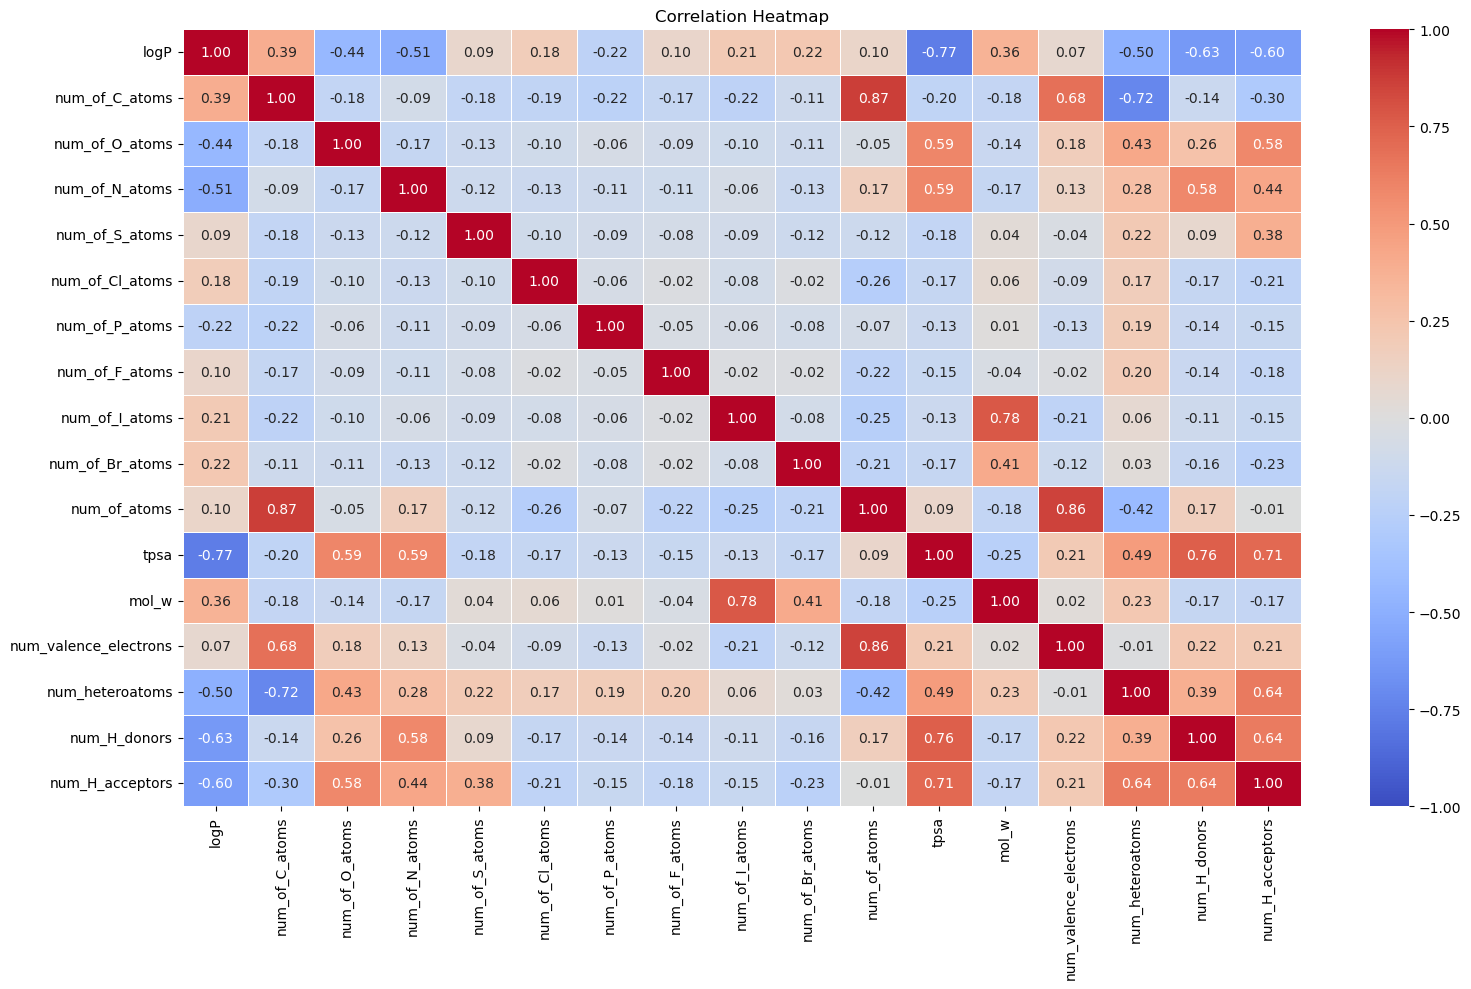

In [110]:
# Compute the correlation matrix
corr = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(16, 10))

# Generate a heatmap
sns.heatmap(corr, annot=True, cmap="coolwarm", vmax=1, vmin=-1, linewidths=.5, fmt=".2f")

# Show the plot
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


From the heatmap we see that there are some correlation:
- logP has a **positive** correlation with number of C atoms and molecular weight
- logP has a **negative** correlation with TPSA, number of H donors, number of H acceptors, number of heteroatoms 
<br><br>There observation make chemical sense.
<br>There are some other correlations that are more obvious. For example, the number of atoms is positively correlated with the number of valence electrons. Another correlation exists between the number of iodine (I) atoms and the molecular weight, which is evident for small molecules.

Now, let's generate a pairplot to once again visualize the correlations, this time including the feature distributions. I will select the most interesting features to avoid overly complicating the visualization.

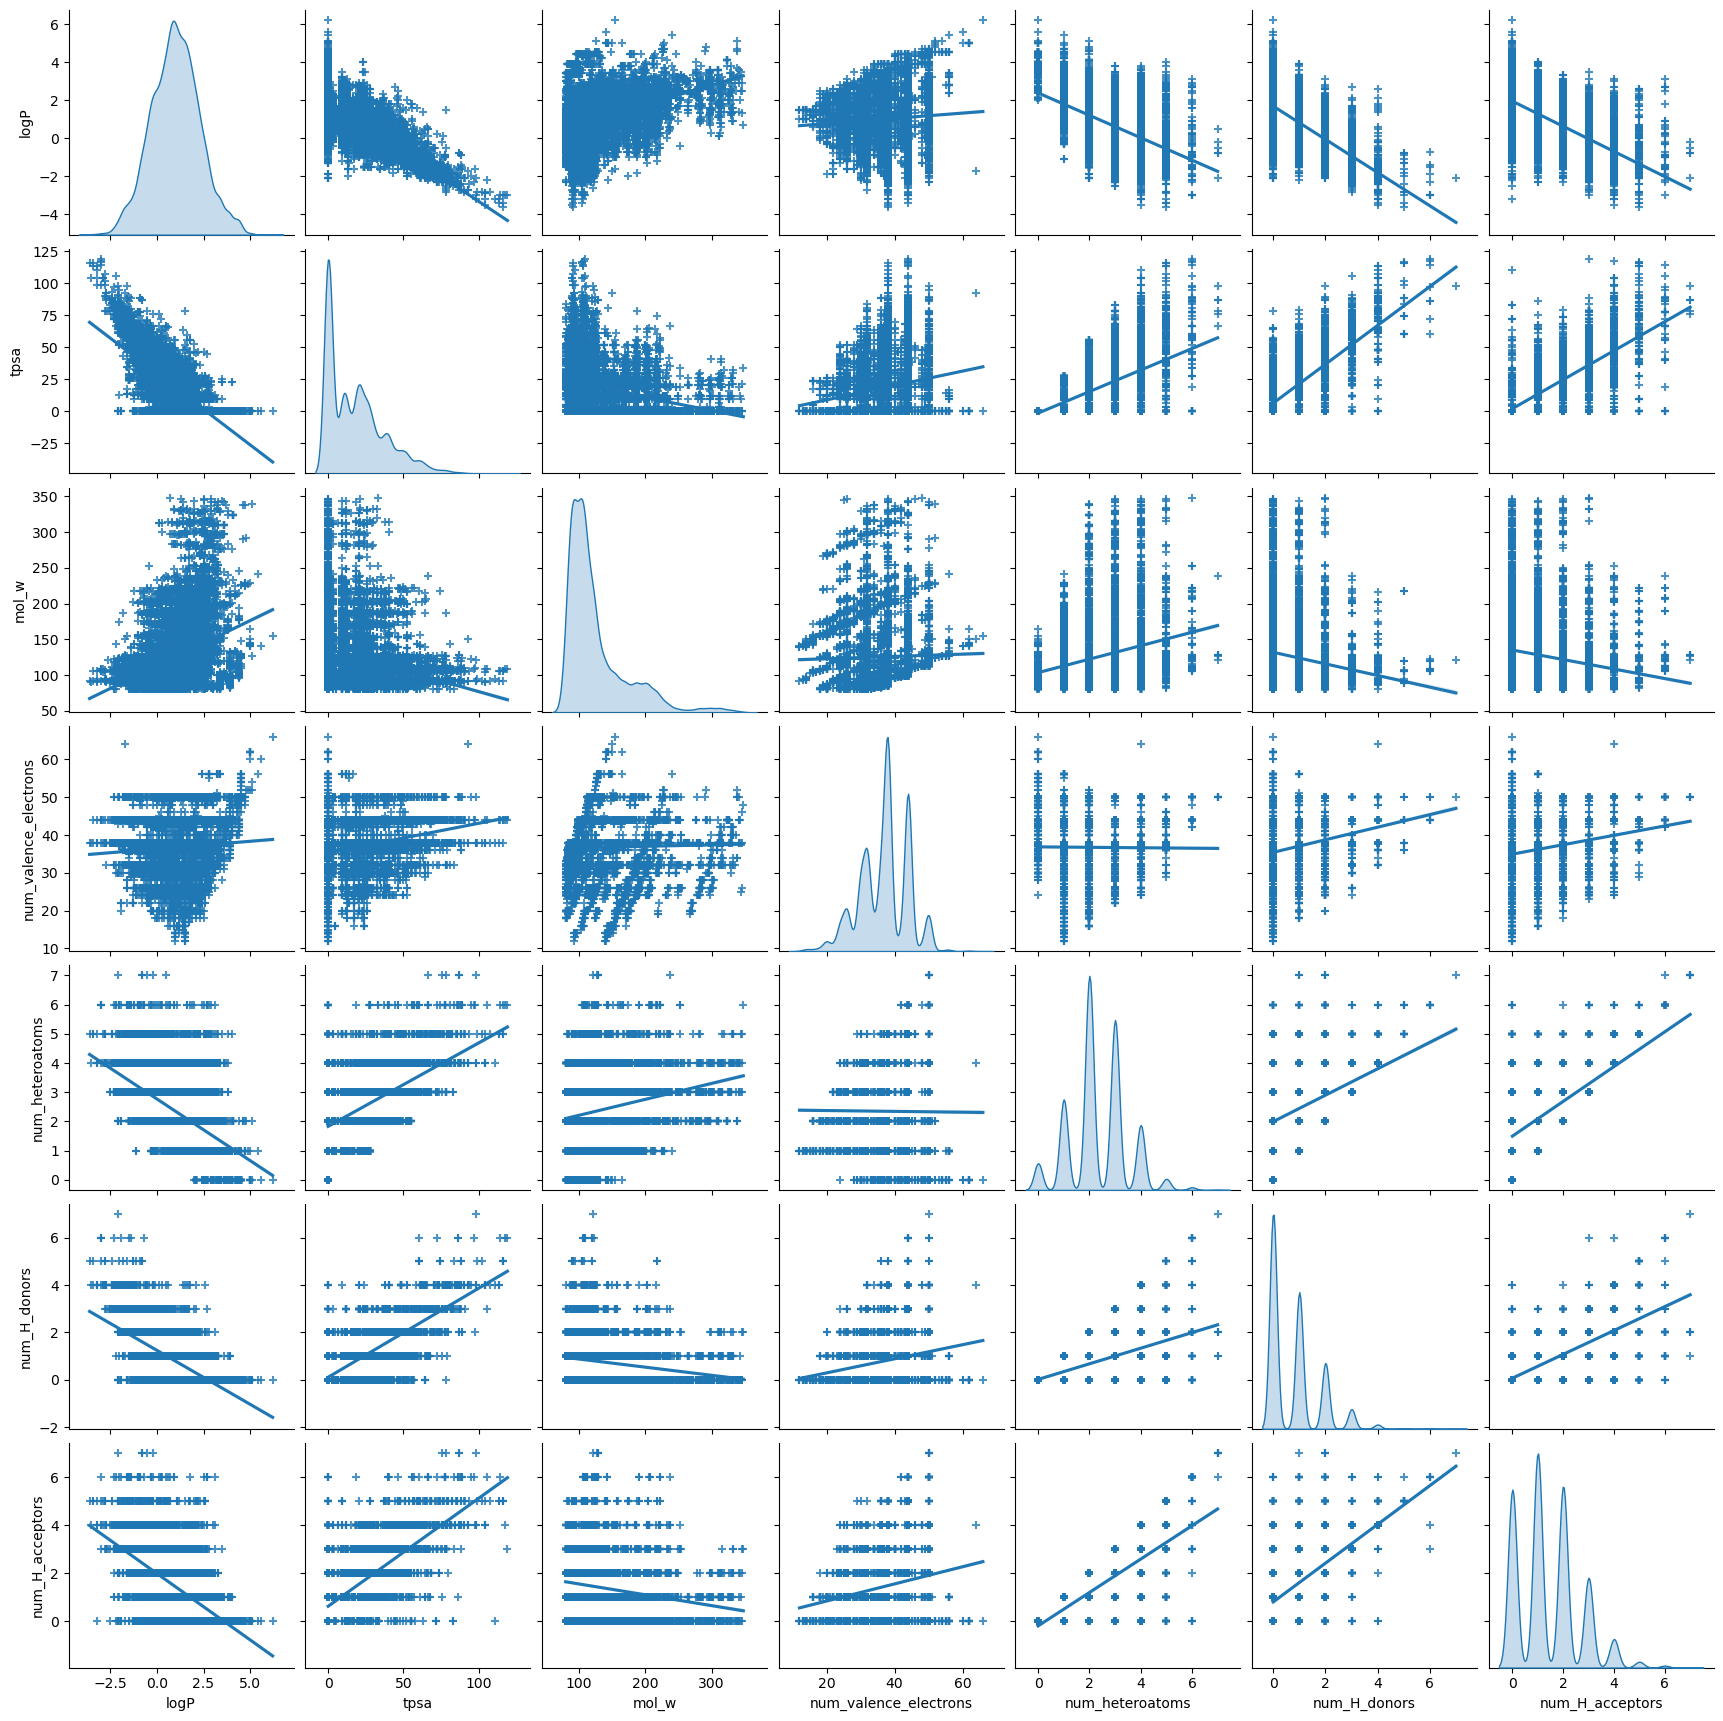

In [13]:
sns.pairplot(df[['logP', 'tpsa', 'mol_w', 'num_valence_electrons', 'num_heteroatoms', 'num_H_donors', 'num_H_acceptors']], diag_kind='kde', kind='reg', markers='+')
plt.show()

The distribution of logP appears to be normal. As expected, the distributions and correlations of the "num_of_x" features are discrete, as are their correlations with each other. The most interesting correlation appears to be the negative one between logP and TPSA.

## Prediction using traditional ML algorithms

Starting from there, one can easily load the feature-engineered DataFrame by:

In [114]:
# importing the dataset
df = pd.read_csv('df.csv')
df.head()

,smiles,logP,mol,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_S_atoms,num_of_Cl_atoms,num_of_P_atoms,num_of_F_atoms,num_of_I_atoms,num_of_Br_atoms,num_of_atoms,tpsa,mol_w,num_valence_electrons,num_heteroatoms,num_H_donors,num_H_acceptors
0,C[C@H]([C@@H](C)Cl)Cl,2.3,<rdkit.Chem.rdchem.Mol object at 0x1409af880>,4,0,0,0,2,0,0,0,0,14,0.00,126.000306,38,2,0,0
1,C(C=CBr)N,0.3,<rdkit.Chem.rdchem.Mol object at 0x1409ae920>,3,0,1,0,0,0,0,0,1,11,26.02,134.968361,30,2,1,1
2,CCC(CO)Br,1.3,<rdkit.Chem.rdchem.Mol object at 0x1409aea40>,4,1,0,0,0,0,0,0,1,15,20.23,151.983677,38,2,1,1
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0,<rdkit.Chem.rdchem.Mol object at 0x1409aeaa0>,6,1,0,0,0,0,0,0,0,21,20.23,108.124594,44,1,1,1
4,CCCOCCP,0.6,<rdkit.Chem.rdchem.Mol object at 0x1409aeb00>,5,1,0,0,0,1,0,0,0,20,9.23,120.070402,44,2,0,1


Let's create the training and testing datasets, and then scale the data using StandardScaler.

In [115]:
# importing libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

# Remove 'mol' and 'smiles' columns from df
df = df.drop(columns=['mol', 'smiles'])

# Split the dataframe in features (X) and target (y)
X = df.drop(columns=['logP'])
y = df['logP']

# Let's train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


# StandardScaler definition
scaler = StandardScaler()

# Fittin the scaler on X_train
X_train = scaler.fit_transform(X_train)

# Transforming the X_test
X_test = scaler.transform(X_test)

## Baseline model with linear regressor

In [118]:
# Let's build a simple linear regressor and fit it
lr = LinearRegression()
lr.fit(X_train, y_train)

# Making predictions
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Computing MAE e RMSE
mae_train_lr = mean_absolute_error(y_train, y_train_pred)
rmse_train_lr = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_test_lr = mean_absolute_error(y_test, y_test_pred)
rmse_test_lr = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("MAE (Training):", mae_train_lr)
print("RMSE (Training):", rmse_train_lr)
print("MAE (Test):", mae_test_lr)
print("RMSE (Test):", rmse_test_lr)


MAE (Training): 0.44540457302053715
RMSE (Training): 0.5873302032107997
MAE (Test): 0.4467243651983805
RMSE (Test): 0.5837812571838478


The baseline linear regressor already shows good metrics. Let's now try a simple Decision Tree Regressor and a Random Forest Regressor.

In [119]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Training and evaluation of DT 
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_train_pred_dt = dt.predict(X_train)
y_pred_dt = dt.predict(X_test)

mae_train_dt = mean_absolute_error(y_train, y_train_pred_dt)
rmse_train_dt = np.sqrt(mean_squared_error(y_train, y_train_pred_dt))
mae_test_dt = mean_absolute_error(y_test, y_pred_dt)
rmse_test_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))

# Training and evaluation of RF
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_train_pred_rf = rf.predict(X_train)
y_pred_rf = rf.predict(X_test)

mae_train_rf = mean_absolute_error(y_train, y_train_pred_rf)
rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
mae_test_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# Creating df to compare the models
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest'],
    'MAE Train': [mae_train_lr, mae_train_dt, mae_train_rf],
    'RMSE Train': [rmse_train_lr, rmse_train_dt, rmse_train_rf],
    'MAE Test': [mae_test_lr, mae_test_dt, mae_test_rf],
    'RMSE Test': [rmse_test_lr, rmse_test_dt, rmse_test_rf]
})

results


,Model,MAE Train,RMSE Train,MAE Test,RMSE Test
0,Linear Regression,0.445405,0.587330,0.446724,0.583781
1,Decision Tree,0.152016,0.247911,0.292009,0.426438
2,Random Forest,0.186293,0.263987,0.276959,0.386765


The Decision Tree Regressor and Random Forest are performing better compared to the Linear Regressor. However, it's important to note that there are signs of **overfitting** in the models.
<br>Now, let's attempt to mitigate the overfitting of the Random Forest model by fine-tuning its hyperparameters using cross-validation.

In [120]:
from sklearn.model_selection import RandomizedSearchCV

# Defining the parameters to test in the random search
param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4]
}

# Creating the Randomized Search model with cross-validation
random_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_dist, cv=5, scoring='neg_mean_absolute_error', n_iter=10, random_state=42, n_jobs=-1)

# Running the random search
random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 150]},
                   random_state=42, scoring='neg_mean_absolute_error')

In [124]:
# Evaluating the best model

best_rf = random_search.best_estimator_
y_train_pred_best_rf = best_rf.predict(X_train)
y_pred_best_rf = best_rf.predict(X_test)

mae_train_best_rf = mean_absolute_error(y_train, y_train_pred_best_rf)
rmse_train_best_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_best_rf))
mae_test_best_rf = mean_absolute_error(y_test, y_pred_best_rf)
rmse_test_best_rf = np.sqrt(mean_squared_error(y_test, y_pred_best_rf))
best_params_rf = random_search.best_params_

print("Best Random Forest Model Metrics:")
print(f"Train MAE: {mae_train_best_rf:.2f}")
print(f"Train RMSE: {rmse_train_best_rf:.2f}")
print(f"Test MAE: {mae_test_best_rf:.2f}")
print(f"Test RMSE: {rmse_test_best_rf:.2f}")
print("Best Parameters:")
print(best_params_rf)


Best Random Forest Model Metrics:
Train MAE: 0.21
Train RMSE: 0.29
Test MAE: 0.28
Test RMSE: 0.38
Best Parameters:
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}


Indeed, our improved Random Forest model performs similarly to the baseline one, but the overfitting issue has been successfully mitigated. This is a positive outcome!

In [125]:
from joblib import dump, load
dump(best_rf, 'random_forest_model.joblib')
#loaded_model = load('random_forest_model.joblib')

['random_forest_model.joblib']

Using a traditional machine learning approach provides us with the opportunity to offer a rational interpretation:

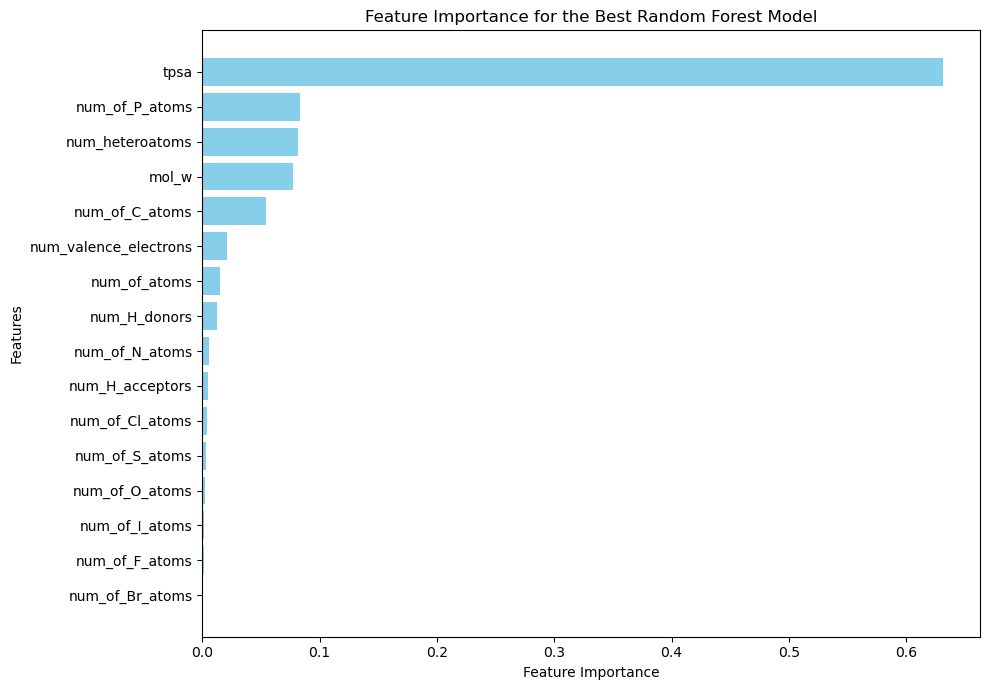

In [126]:
# Obtain feature importances
feature_importances = best_rf.feature_importances_

# Sort features based on importance
sorted_idx = feature_importances.argsort()

# Create a more visually appealing bar plot for feature importance
plt.figure(figsize=(10, 7))
plt.barh(X.columns[sorted_idx], feature_importances[sorted_idx], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance for the Best Random Forest Model")
plt.tight_layout()
plt.show()



The most important feature is TPSA, which stands for Topological Polar Surface Area, is a molecular descriptor that quantifies the polar surface area of a molecule. It measures the portion of the molecular surface that is polarized and can engage in polar interactions such as hydrogen bonding and electrostatic interactions. TPSA is particularly useful for predicting properties related to solubility, cell permeability, and other molecular characteristics tied to polar interactions.
<br> TPSA is followed by the number of P atoms (which is a surprise), the number of heteroatoms, molecular weight, and so on.

I would like to acknowledge the inspiration drawn from the Kaggle notebook titled "Tutorial: Machine Learning in Chemistry Research with RDKit & Mol2Vec" by Vlad Kisin available at (https://www.kaggle.com/code/vladislavkisin/tutorial-ml-in-chemistry-research-rdkit-mol2vec). The insights and approaches discussed in the notebook provided valuable guidance throughout the development of this project.


